# Clustering In Anomaly Detection

Clustering : DBSCAN

= Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.  
= Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.  
= Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).  


In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


In [2]:
from env import host, username, password

def get_db_url(database, host=host, username=username, password=password):
    return f'mysql+pymysql://{username}:{password}@{host}/{database}'


In [3]:
# obtaining data

url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col = "customer_id")
df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df = df.rename(columns = {'Fresh' : 'fresh', 'Milk' : 'milk', 'Grocery' : 'grocery', 
                          'Frozen' : 'frozen', 'Detergents_Paper': 'dried_goods', 
                          'Delicassen' : 'deli' })

In [5]:
df = df.drop(columns = ['Channel', 'Region'])

In [6]:
df.columns

Index(['fresh', 'milk', 'grocery', 'frozen', 'dried_goods', 'deli'], dtype='object')

In [10]:
mylist = ['fresh', 'milk', 'grocery', 'frozen',
       'dried_goods', 'deli']

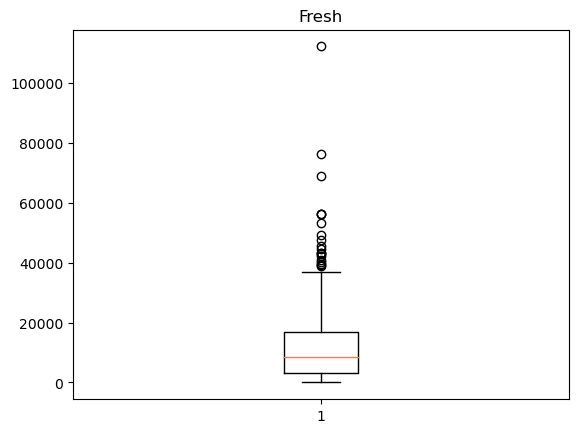

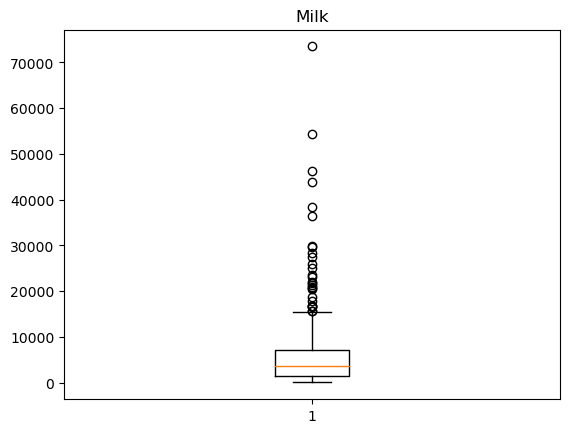

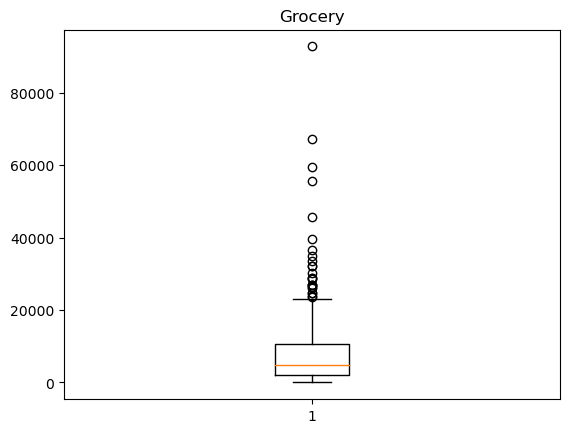

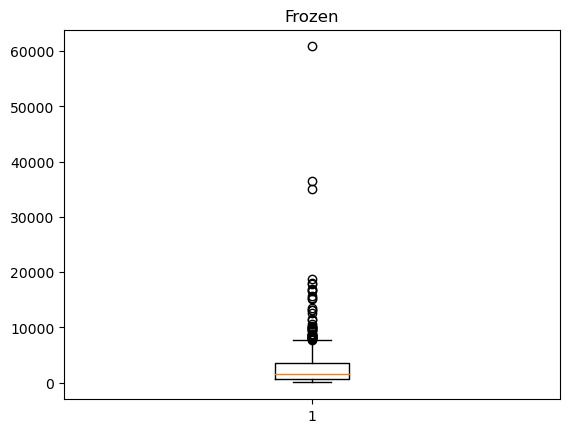

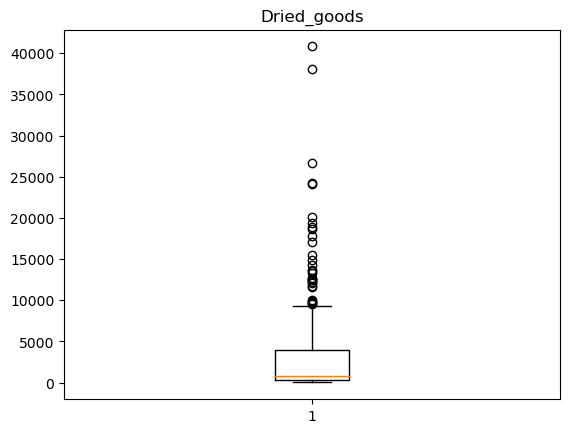

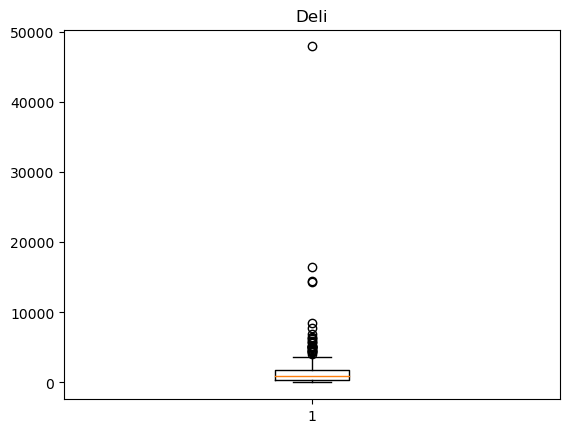

In [11]:
# histograms to look at distribution and outliers

for col in mylist :
    plt.boxplot(df[col])
    plt.title(col.replace('.','_').capitalize())
    plt.show()

### = Use DBSCAN to detect anomalies in other products from the customers dataset. 

In [12]:
# clustering on deli, frozen, dried_goods

deli_fro_dry = df[['deli', 'frozen', 'dried_goods']]

deli_fro_dry.head(3)

,deli,frozen,dried_goods
customer_id,,,
0,1338,214,2674
1,1776,1762,3293
2,7844,2405,3516


Clustering on deli, frozen and dried goods as they all have packaging or fall into a category of on-the-run, celebration / party, single-use or 'I don't like to cook'.

Step #3

In [13]:
# Make the scaler

scaler = MinMaxScaler()

# fit the scaler

scaler.fit(deli_fro_dry)

# apply the scaler
deli_fro_dry = scaler.transform(deli_fro_dry)

deli_fro_dry

array([[0.02784731, 0.0031063 , 0.0654272 ],
       [0.03698373, 0.02854842, 0.08058985],
       [0.16355861, 0.03911643, 0.08605232],
       ...,
       [0.03888194, 0.00677142, 0.36346267],
       [0.04426366, 0.01664914, 0.00404174],
       [0.00102211, 0.00065742, 0.01161082]])

In [41]:
# add scaled-value cols onto original dataframe

cols = ['deli', 'frozen', 'dried_goods']
scaled_cols = ['scaled_' + col for col in cols]

# save a copy of original df

orig_df = df.copy()

# make a df w the scaled values

scaled_df = pd.DataFrame(deli_fro_dry, columns = scaled_cols)

# scaled df

scaled_df.head(2)

,scaled_deli,scaled_frozen,scaled_dried_goods
0,0.027847,0.003106,0.065427
1,0.036984,0.028548,0.080590


In [42]:
# merge onto original df

df= df.merge(scaled_df, on = df.index)

df = df.drop(columns = ['key_0'])

df.head()


,fresh,milk,grocery,frozen,dried_goods,deli,scaled_deli_x,scaled_frozen_x,scaled_dried_goods_x,labels,scaled_deli_y,scaled_frozen_y,scaled_dried_goods_y
0,12669,9656,7561,214,2674,1338,0.027847,0.003106,0.065427,0,0.027847,0.003106,0.065427
1,7057,9810,9568,1762,3293,1776,0.036984,0.028548,0.080590,0,0.036984,0.028548,0.080590
2,6353,8808,7684,2405,3516,7844,0.163559,0.039116,0.086052,0,0.163559,0.039116,0.086052
3,13265,1196,4221,6404,507,1788,0.037234,0.104842,0.012346,0,0.037234,0.104842,0.012346
4,22615,5410,7198,3915,1777,5185,0.108093,0.063934,0.043455,0,0.108093,0.063934,0.043455


In [43]:
# Merge the scaled and non-scaled values into one dataframe

df = df.merge(scaled_df, on = df.index)

df = df.drop(columns = ['key_0'])
df.sample(5)

,fresh,milk,grocery,frozen,dried_goods,deli,scaled_deli_x,scaled_frozen_x,scaled_dried_goods_x,labels,scaled_deli_y,scaled_frozen_y,scaled_dried_goods_y,scaled_deli,scaled_frozen,scaled_dried_goods
295,7588,1897,5234,417,2208,254,0.005236,0.006443,0.054012,0,0.005236,0.006443,0.054012,0.005236,0.006443,0.054012
439,2787,1698,2510,65,477,52,0.001022,0.000657,0.011611,0,0.001022,0.000657,0.011611,0.001022,0.000657,0.011611
248,15671,5279,2406,559,562,572,0.011869,0.008777,0.013693,0,0.011869,0.008777,0.013693,0.011869,0.008777,0.013693
137,3087,8080,8282,661,721,36,0.000688,0.010453,0.017588,0,0.000688,0.010453,0.017588,0.000688,0.010453,0.017588
96,23,2616,8118,145,3874,217,0.004464,0.001972,0.094822,0,0.004464,0.001972,0.094822,0.004464,0.001972,0.094822


Weird. The code added suffexes to the scaled columns. The columns _x and _y, however, have equal values.

In [44]:
# dropping redundant 

df = df.drop(columns = ['scaled_deli_x', 'scaled_frozen_x', 'scaled_dried_goods_x'])

In [45]:
df.sample()

,fresh,milk,grocery,frozen,dried_goods,deli,labels,scaled_deli_y,scaled_frozen_y,scaled_dried_goods_y,scaled_deli,scaled_frozen,scaled_dried_goods
321,9155,1897,5167,2714,228,1113,0,0.023154,0.044195,0.005511,0.023154,0.044195,0.005511


In [46]:
# renaming 

df = df.rename(columns = {'scaled_deli_y' : 'scaled_deli', 'scaled_frozen_y' : 'scaled_frozen',
                         'scaled_dried_goods_y' : 'scaled_dried_goods'})

In [47]:
df.sample()

,fresh,milk,grocery,frozen,dried_goods,deli,labels,scaled_deli,scaled_frozen,scaled_dried_goods,scaled_deli,scaled_frozen,scaled_dried_goods
35,688,5491,11091,833,4239,436,0,0.009032,0.01328,0.103762,0.009032,0.01328,0.103762


**Use DBSCAN.**

In [48]:
# make the DBSCAN 

dibs = DBSCAN(eps = 0.10, min_samples = 20)

# fit the DBSCAN object to 'deli_fro_dry'

dibs.fit(deli_fro_dry)

DBSCAN(eps=0.1, min_samples=20)

In [49]:
# assign cluster labels, bc cluster labels don't mean anything in and of themselves

df['labels10'] = dibs.labels_

# the DBSCAN '-1' contains the number of outliers (the noise)
df['labels'].value_counts()

 0    423
-1     17
Name: labels, dtype: int64

There are 17 outliers.

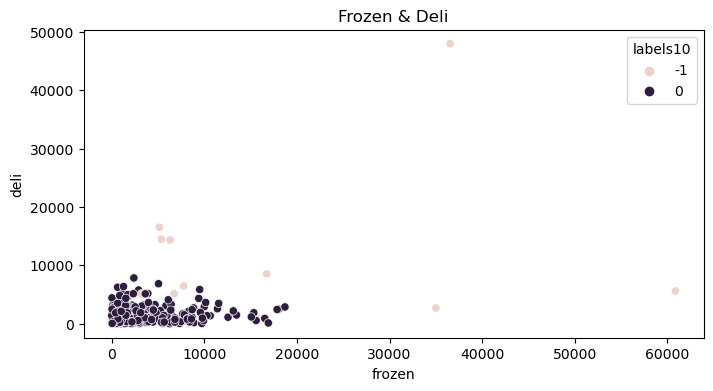

In [50]:
# plotting the outliers for frozen & deli

plt.figure(figsize = (8, 4))
sns.scatterplot(x = df['frozen'], y = df['deli'], hue = df['labels10'])
plt.title('Frozen & Deli')
plt.show()

There are som frozen outliers at about 35000 and 61000, and a frozen + deli outlier at about 36000 frozen & 49000 deli.

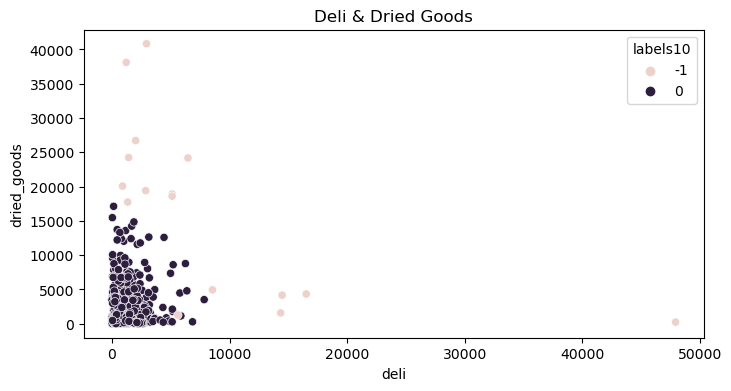

In [51]:
# plotting deli & dried_goods

plt.figure(figsize = (8, 4))
sns.scatterplot(x=df['deli'], y=df['dried_goods'], hue = df['labels10'])
plt.title('Deli & Dried Goods')
plt.show()


There's a cluster of outliers for deli at about 15000 – 16000 deli, and another deli outlier at about 48000. There are dried goods outliers above about 17000 on dried goods.

In [32]:
# creating df of only the anomalies

anoms = df.loc[df['labels'] == -1]

anoms.sample(10)

,fresh,milk,grocery,frozen,dried_goods,deli,scaled_deli,scaled_frozen,scaled_dried_goods,labels
47,44466,54259,55571,7782,24171,6465,0.134793,0.127490,0.592005,-1
23,26373,36423,22019,5154,4337,16523,0.344597,0.084298,0.106163,-1
93,11314,3090,2062,35009,71,2698,0.056216,0.574979,0.001666,-1
333,8565,4980,67298,131,38102,1215,0.025282,0.001742,0.933250,-1
211,12119,28326,39694,4736,19410,2870,0.059804,0.077428,0.475382,-1
92,9198,27472,32034,3232,18906,5130,0.106946,0.052709,0.463036,-1
325,32717,16784,13626,60869,1272,5609,0.116938,1.000000,0.031085,-1
71,18291,1266,21042,5373,4173,14472,0.301815,0.087897,0.102146,-1
56,4098,29892,26866,2616,17740,1340,0.027889,0.042584,0.434475,-1
181,112151,29627,18148,16745,4948,8550,0.178285,0.274801,0.121130,-1


Now experimenting with varying the eps

In [33]:
# make the DBSCAN with eps = 0.20

dibs20 = DBSCAN(eps = 0.20, min_samples = 20)

# fit the DBSCAN object to 'deli_fro_dry'

dibs20.fit(deli_fro_dry)

DBSCAN(eps=0.2, min_samples=20)

In [52]:
# assign cluster labels, bc cluster labels don't mean anything in and of themselves

df['labels20'] = dibs20.labels_

# the DBSCAN '-1' contains the number of outliers (the noise)
df['labels20'].value_counts()

 0    435
-1      5
Name: labels20, dtype: int64

There are fewer outliers when the distance between the datapoints is farther. This is logical, as we're clustering.

In [53]:
# make the DBSCAN with eps = 0.05

dibs5 = DBSCAN(eps = 0.05, min_samples = 20)

# fit the DBSCAN object to 'deli_fro_dry'

dibs5.fit(deli_fro_dry)

# assign cluster labels, bc cluster labels don't mean anything in and of themselves

df['labels5'] = dibs5.labels_

# the DBSCAN '-1' contains the number of outliers (the noise)
df['labels5'].value_counts()

 0    389
-1     51
Name: labels5, dtype: int64

Now there are more outliers. 

In [54]:
# make the DBSCAN with eps = 0.15

dibs15 = DBSCAN(eps = 0.15, min_samples = 20)

# fit the DBSCAN object to 'deli_fro_dry'

dibs15.fit(deli_fro_dry)

# assign cluster labels, bc cluster labels don't mean anything in and of themselves

df['labels15'] = dibs15.labels_

# the DBSCAN '-1' contains the number of outliers (the noise)
df['labels15'].value_counts()

 0    429
-1     11
Name: labels15, dtype: int64

num anomalies :  
51 - 17 - 11 - 5  
eps :   
0.05, 0.1, 0.15, 0.2  

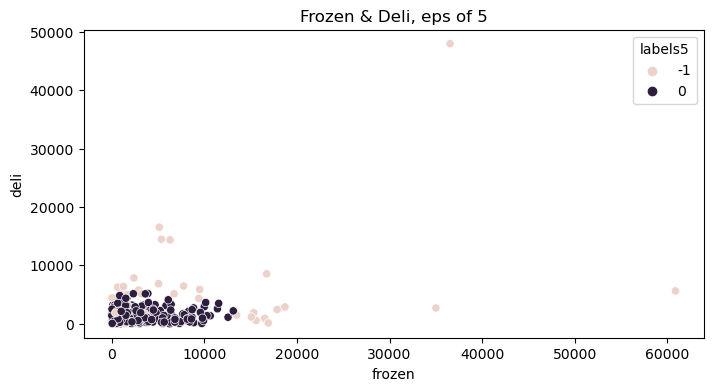

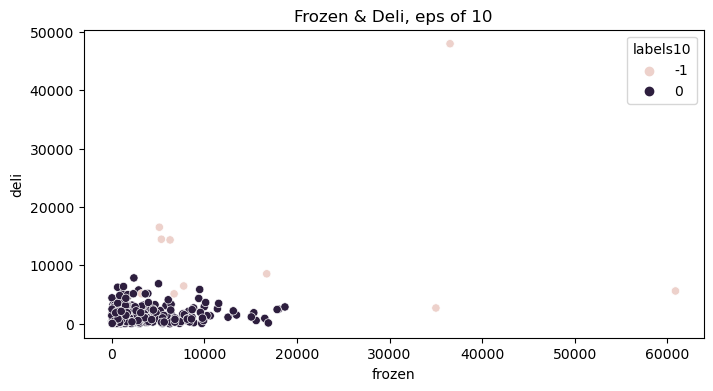

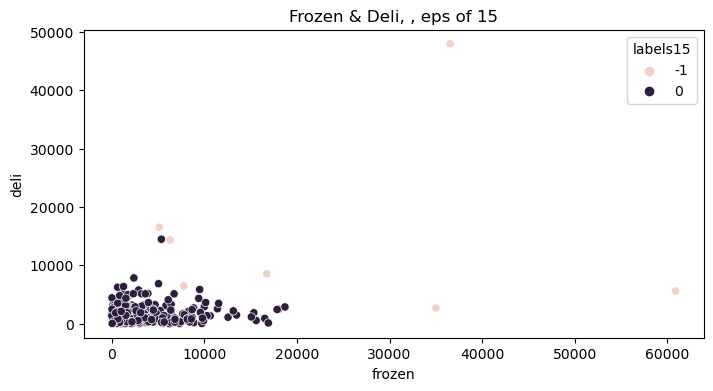

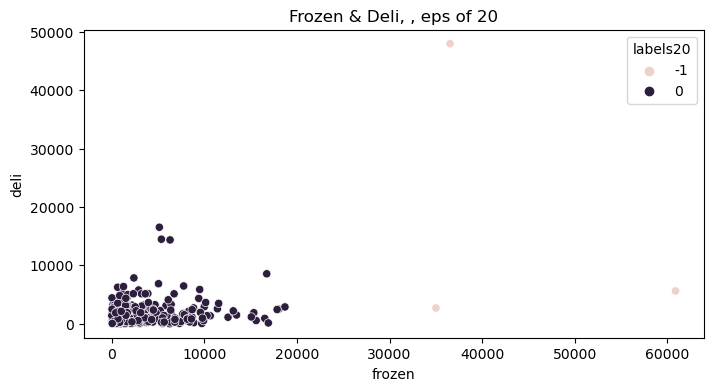

In [57]:
# plotting the outliers for frozen & deli
# varying eps

plt.figure(figsize = (8, 4))
sns.scatterplot(x = df['frozen'], y = df['deli'], hue = df['labels5'])
plt.title('Frozen & Deli, eps of 5')
plt.show()


plt.figure(figsize = (8, 4))
sns.scatterplot(x = df['frozen'], y = df['deli'], hue = df['labels10'])
plt.title('Frozen & Deli, eps of 10')
plt.show()


plt.figure(figsize = (8, 4))
sns.scatterplot(x = df['frozen'], y = df['deli'], hue = df['labels15'])
plt.title('Frozen & Deli, eps of 15')
plt.show()


plt.figure(figsize = (8, 4))
sns.scatterplot(x = df['frozen'], y = df['deli'], hue = df['labels20'])
plt.title('Frozen & Deli, eps of 20')
plt.show()

In [69]:
# make the DBSCAN with eps = 0.15, min_samples = 250

dibs15_250 = DBSCAN(eps = 0.15, min_samples = 250)

# fit the DBSCAN object to 'deli_fro_dry'

dibs15_250.fit(deli_fro_dry)

# assign cluster labels, bc cluster labels don't mean anything in and of themselves

df['labels15_250'] = dibs15.labels_

# the DBSCAN '-1' contains the number of outliers (the noise)
df['labels15_250'].value_counts()

 0    411
-1     29
Name: labels15_250, dtype: int64

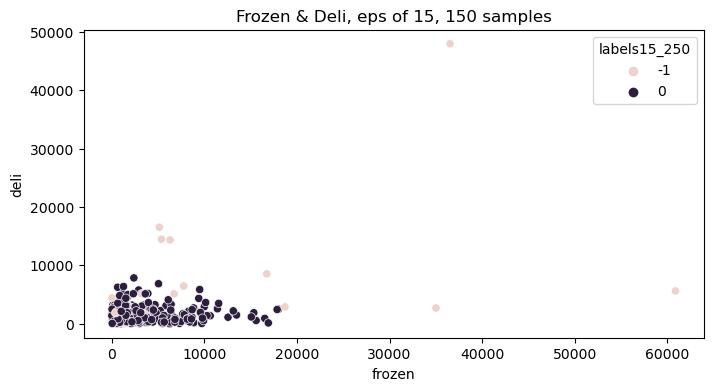

In [70]:
# plotting eps 15, min samples 250

plt.figure(figsize = (8, 4))
sns.scatterplot(x = df['frozen'], y = df['deli'], hue = df['labels15_250'])
plt.title('Frozen & Deli, eps of 15, 150 samples')
plt.show()

Increasing the minimun samples also decreases the number of anomalies. This is because more datapoints have to be present around the central cluster point in order to form a cluster.